# US Region vs Senate Party Timeline

This is the source code for a stacked area plot of senator party makeup from the 4 different regions of the US. The senator terms used are from 1914 (beginning of direct election of senators) to 2020.

Data obtained from https://github.com/unitedstates/congress-legislators

Author: https://github.com/ParkerD559/

In [1]:
import json
from pprint import pprint

START_YEAR = 1914
END_YEAR = 2020
TERM_TYPE = 'sen'
PARTY_COLORS = {
    'Republican': '#de0100',
    'Democrat': '#0015bc',
    'Independent': '#dddddd',
    'Conservative': '#ff5fed',
    'Farmer-Labor': '#00d3dd',
    'Progressive': '#44b230'
}


def extract_info(members, output):
    for member in members:
        for term in member['terms']:
            if term['type'] == TERM_TYPE:
                start_year = int(term['start'][:4])
                end_year = int(term['end'][:4])
                
                for year in range(start_year, end_year):
                    if START_YEAR <= year <= END_YEAR:
                        state = term['state']
                        
                        if year not in output:
                            output[year] = {}
                        if state not in output[year]:
                            output[year][state] = []
                        output[year][state].append(term['party'])


def fill_data(filename, output):
    with open(filename) as data:
        extract_info(json.load(data), output)

In [2]:
senate_data = {}
fill_data('legislators-historical.json', senate_data)
fill_data('legislators-current.json', senate_data)

In [3]:
regions = {
    "Northeast": ['CT', 'ME', 'MA', 'NH', 'RI', 'VT', 'NJ', 'NY', 'PA'],
    "Midwest": ['MN', 'MO', 'IL', 'IN', 'MI', 'OH', 'WI', 'IA', 'KS', 'NE', 'ND', 'SD'],
    "South": ['AL', 'MS', 'TN', 'DE', 'FL', 'GA', 'MD', 'NC', 'SC', 'VA', 'WV', 'KY', 'AR', 'LA', 'OK', 'TX'],
    "West": ['AZ', 'UT', 'CO', 'ID', 'MT', 'NV', 'NM', 'WY', 'AK', 'CA', 'HI', 'OR', 'WA']
}

def party_ratio(year, region):
    counts = {}
    for state in regions[region]:
        parties = senate_data[year].get(state)
        if parties:
            for party in parties:
                if party not in counts:
                    counts[party] = 0
                counts[party] += 1
    total_senators = sum(counts.values())
    return {k: (val / total_senators) for k, val in counts.items()}

In [4]:
%matplotlib notebook
import pandas as pd
import matplotlib.pyplot as plt

years = range(START_YEAR, END_YEAR + 1)

In [5]:
plt.rcParams['figure.figsize'] = (9, 9)
def add_plot(region, figure):
    ax = fig.add_subplot(4, 1, list(regions.keys()).index(region) + 1)
    data = pd.DataFrame([party_ratio(year, region) for year in years]).fillna(0)
    colors = [PARTY_COLORS[party] for party in data.keys().sort_values()]
    ax.stackplot(years, data.values.T, labels=data.keys(), colors=colors)
    ax.set_title(region, loc='left')
    ax.margins(0,0)
    ax.set_yticks([0, .5, 1])
    ax.set_xticks([tick for tick in years if tick % 8 == 2])
    ax.set_xticks([tick for tick in years if tick % 2 == 0], minor=True)
    ax.grid(axis='both', which='both', linestyle='-', alpha=0.2)
    return ax

<IPython.core.display.Javascript object>


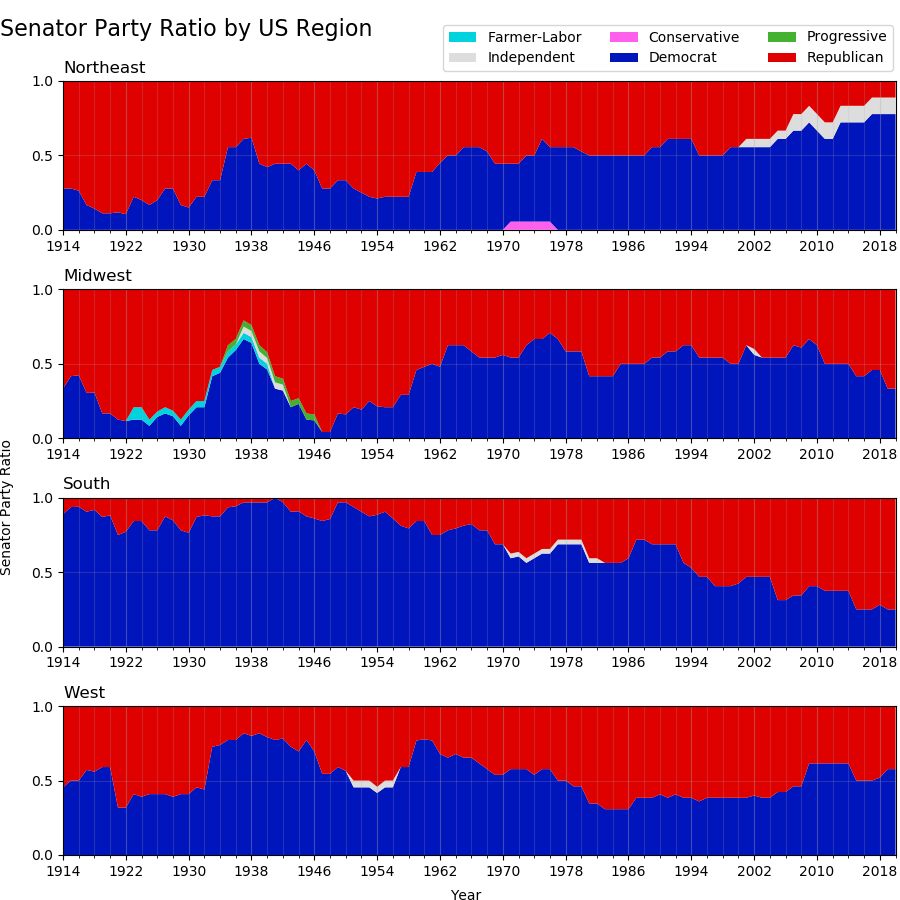

In [6]:
fig = plt.figure()
subplots = []
for region in regions.keys():
    subplots.append(add_plot(region, fig))
from collections import ChainMap
by_label = dict(ChainMap(
    *[dict(zip(labels, handles))
        for handles, labels in 
            [s.get_legend_handles_labels() 
                for s in subplots]
            ]
    ))
fig.suptitle('Senator Party Ratio by US Region', x=0, horizontalalignment='left', fontsize=16)
fig.text(0.5, 0, 'Year')
fig.text(0, 0.5, 'Senator Party Ratio', rotation='vertical')
fig.legend(by_label.values(), by_label.keys(), ncol=3, bbox_to_anchor=(1, 0.98))
fig.tight_layout(pad=0)
_ = fig.subplots_adjust(top=0.91, hspace=0.4, left=0.07, bottom=0.05)